<a href="https://colab.research.google.com/github/JaccoVeldscholten/SmartDispenser/blob/main/BAVA_TVOC_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
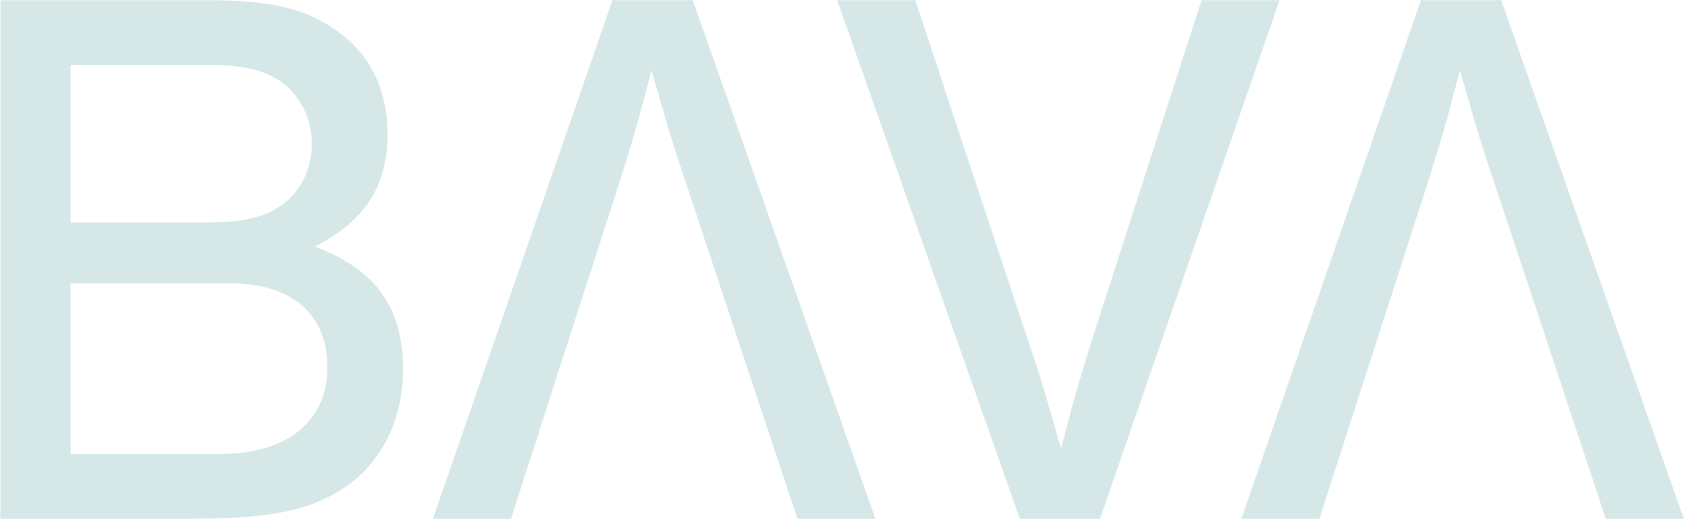
</div>

**API Validation & Prediction** <br>
This document will be validate the gathered API Data and will is able to being used for predictions and analyses

***Temperature Prediction*** <br>
To start off Machine Learning is being used to predict the temperature of the certain amount of days in the toilet. By using basic regression model (linear) its possible to predict the temperature based on the API data thats being generated by the device.

# Imports <br>
In the first stage of the notebook all imports should be made for running the code later on in the notebook

In [70]:
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Disable copy warn
pd.options.mode.chained_assignment = None  # default='warn'

2.7.0


# Fetching API <br>
First gather the API Data from the URL. After that print the first elements of the fetched data

In [71]:
with urllib.request.urlopen("https://us-central1-bava-solutions.cloudfunctions.net/getAllDeviceData") as url:
    data = json.loads(url.read().decode())

In [72]:
df = pd.DataFrame(data)
df.tail()
# df['timestamp'][0]

,timestamp,occupied,batterylevel,waterlevel,tvoc_co2,pressure,tvoc_ppm,hum,altitude,temp,mac
491,"{'_seconds': 1638267950, '_nanoseconds': 30800...",False,100,100,169,100294,3,45,89,19,4C:EB:D6:74:46:C4
492,"{'_seconds': 1638268576, '_nanoseconds': 13000...",False,100,100,153,100285,1,44,90,19,4C:EB:D6:74:46:C4
493,"{'_seconds': 1638272021, '_nanoseconds': 21300...",False,100,100,165,100332,3,45,86,18,4C:EB:D6:74:46:C4
494,"{'_seconds': 1638272643, '_nanoseconds': 62800...",False,100,100,147,100338,0,45,85,18,4C:EB:D6:74:46:C4
495,"{'_seconds': 1638340123, '_nanoseconds': 82200...",False,100,100,168,99000,3,47,202,20,4C:EB:D6:74:46:C4


# Plotting the data

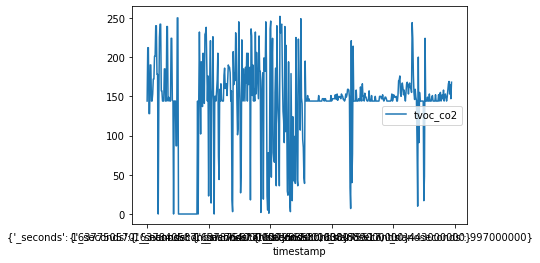

In [73]:
df.plot(x='timestamp', y='tvoc_co2')

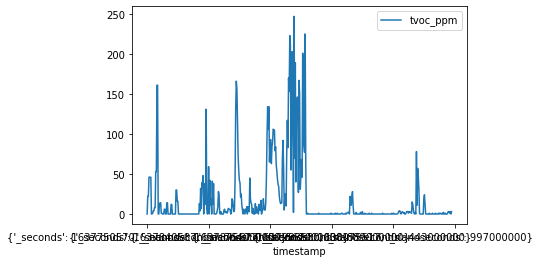

In [74]:
# Reading TVOC
df = pd.DataFrame(data)
df.plot(x='timestamp', y='tvoc_ppm')

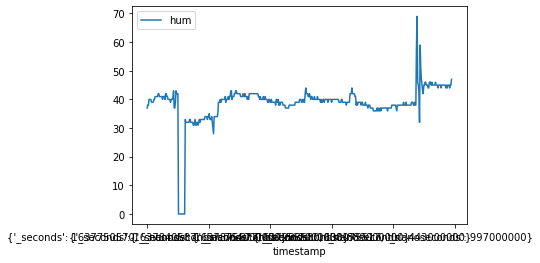

In [75]:
# Reading humidty
df.plot(x='timestamp', y='hum')

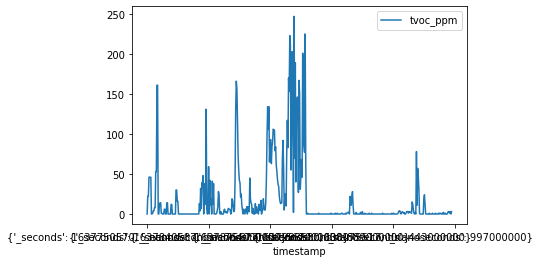

In [76]:
# Reading tvoc_ppmerature
df.plot(x='timestamp', y='tvoc_ppm')

# The numbers mason <br>
The numbers mason what do they mean?

In [77]:
# Getting all triggers by occupation
triggerd_by_occupation = df[df['occupied']==1]
triggerd_by_occupation.count()['occupied']

46

In [78]:
# Getting all triggers by timer
triggerd_by_timer = df[df['occupied']==0]
triggerd_by_timer.count()['occupied']

450

# Predictions <br>
**Predictions based on Machine learning data**<br> 
First prediction is determining what the temperature might be in a few days.


In [79]:
# Tensorflow
np.set_printoptions(precision=3, suppress=True)

#Clean the data. Drop any columns with missing values or null values.

dropping timestamp and mac because they are categorical and irrelevant.

dropping batterylevel and waterlevel because they all have same data.

In [80]:
dataset = df.copy()
dataset.isna().sum()

#dataset.dropna()
cleaned_dataset = dataset.drop(['mac', 'batterylevel', 'waterlevel', 'occupied'], axis=1)

tvoc_ppm = cleaned_dataset

for i in range(len(cleaned_dataset['timestamp'])):
  cleaned_dataset['timestamp'][i] = datetime.datetime.utcfromtimestamp((cleaned_dataset['timestamp'][i]['_seconds']) ).strftime('%Y-%m-%d')

cleaned_dataset.index = pd.to_datetime(cleaned_dataset['timestamp'])
cleaned_dataset = cleaned_dataset[cleaned_dataset['temp'] != 0]
cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)
#cleaned_dataset


#Splitting for regression using Tensorflow

In [81]:

train_data = cleaned_dataset.sample(frac=0.5, random_state=0)

test_data = cleaned_dataset.sample(frac=0.2, random_state=0)

# test_data

# cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)

# train_data, test_data = np.split(cleaned_dataset, [int(.3 *len(data))])

train_data
print(len(test_data), len(train_data), len(cleaned_dataset))

# Y = cleaned_dataset['tvoc_ppm']
# x = cleaned_dataset.loc[:, cleaned_dataset.columns != 'tvoc_ppm']

97 242 485


#Split attributes and labels apart

In [82]:
train_features = cleaned_dataset.copy()
test_features = cleaned_dataset.copy()

train_labels = train_features.pop('tvoc_ppm')
test_labels = test_features.pop('tvoc_ppm')



train_labels

train_data = train_data.drop(['tvoc_ppm'], axis=1)
test_data = test_data.drop(['tvoc_ppm'], axis=1)

print(test_data)

# train_dataset_timeseries = keras.preprocessing.timeseries_dataset_from_array(train_data, train_labels, sequence_length=len(train_data))
# TimeSeries

            tvoc_co2  pressure  hum  altitude  temp
timestamp                                          
2021-11-24       240    102190   41       -74    22
2021-11-27       159     98498   39       246    20
2021-11-25        57    100814   41        44    19
2021-11-28       144     99342   37       173    19
2021-11-25       146    100968   35        31    23
...              ...       ...  ...       ...   ...
2021-11-28        88     99631   69       147    20
2021-11-30        48    100190   45        98    19
2021-11-28       155     99563   39       153    18
2021-11-27       144     98212   42       271    19
2021-11-26       195     98239   42       269    18

[97 rows x 5 columns]


In [83]:
train_stat = train_data.describe().transpose()[['mean', 'std']]
train_stat

,mean,std
tvoc_co2,141.966942,58.909585
pressure,99973.925620,1229.616991
hum,39.483471,4.265287
altitude,117.462810,106.969383
temp,19.681818,1.804214


#Normalization
***Normalizing is helpful to bound data between the range from 0 to 1***

In [84]:
def normalize(row):
  # t = row['timestamp']
  

  answer = (row - train_stat['mean']) / train_stat['std']
  print(row, answer)
  # answer['timestamp'] = t
  
  return answer

normed_train = normalize(train_data)
normed_test = normalize(test_data)

print(normed_test)



normed_train = np.asarray(normed_train).astype(np.float32)
normed_test = np.asarray(normed_test).astype(np.float32)

# normed_train
# normed_test
train_labels

            tvoc_co2  pressure  hum  altitude  temp
timestamp                                          
2021-11-24       240    102190   41       -74    22
2021-11-27       159     98498   39       246    20
2021-11-25        57    100814   41        44    19
2021-11-28       144     99342   37       173    19
2021-11-25       146    100968   35        31    23
...              ...       ...  ...       ...   ...
2021-11-25        36    100642   40        59    18
2021-11-25       182    100771   41        48    18
2021-11-27       144     98201   41       272    19
2021-11-27        34     98648   42       233    21
2021-11-30       144    100255   45        93    19

[242 rows x 5 columns]             tvoc_co2  pressure       hum  altitude      temp
timestamp                                                   
2021-11-24  1.664127  1.802248  0.355551 -1.789884  1.284871
2021-11-27  0.289139 -1.200313 -0.113350  1.201626  0.176355
2021-11-25 -1.442328  0.683200  0.355551 -0.686765 -0.37

timestamp
2021-11-24     0
2021-11-24    22
2021-11-24    22
2021-11-24    46
2021-11-24    46
              ..
2021-11-30     3
2021-11-30     1
2021-11-30     3
2021-11-30     0
2021-12-01     3
Name: tvoc_ppm, Length: 485, dtype: int64

#Building the model using Tensorflow Keras

In [85]:
# For building the model using function for in the future its better to create multiple models
def create_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_data.keys())]),
      layers.Dense(1)
  ])

  optimiser = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimiser, metrics=['mae', 'mse'])

  return model

In [86]:
model = create_model()

#Insights of the model

In [87]:
model.summary() # Overview of the created model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                384       
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [88]:
early_block = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)                                     # Add auto stop incase the loss is less enough.
full_model = model.fit(normed_train, train_labels, epochs=10000, validation_split=0.2, callbacks=[early_block])   # Actual model training

Epoch 1/10000
7/7 [==============================] - 1s 33ms/step - loss: 1527.3215 - mae: 19.0944 - mse: 1527.3215 - val_loss: 11344.1533 - val_mae: 85.4105 - val_mse: 11344.1533
Epoch 2/10000
7/7 [==============================] - 0s 6ms/step - loss: 1519.3008 - mae: 19.0058 - mse: 1519.3008 - val_loss: 11317.9873 - val_mae: 85.2617 - val_mse: 11317.9873
Epoch 3/10000
7/7 [==============================] - 0s 6ms/step - loss: 1513.3724 - mae: 18.9645 - mse: 1513.3724 - val_loss: 11295.3008 - val_mae: 85.1308 - val_mse: 11295.3008
Epoch 4/10000
7/7 [==============================] - 0s 8ms/step - loss: 1507.7482 - mae: 18.9179 - mse: 1507.7482 - val_loss: 11270.9971 - val_mae: 84.9879 - val_mse: 11270.9971
Epoch 5/10000
7/7 [==============================] - 0s 6ms/step - loss: 1501.8239 - mae: 18.8762 - mse: 1501.8239 - val_loss: 11249.6836 - val_mae: 84.8643 - val_mse: 11249.6836
Epoch 6/10000
7/7 [==============================] - 0s 8ms/step - loss: 1496.7631 - mae: 18.8413 - mse:

# Model training validation
How well did the model trained? How is the loss?


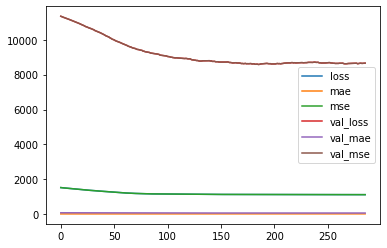

In [89]:
losses = pd.DataFrame(model.history.history)
losses.plot() # Plot the loss

## Model Testing


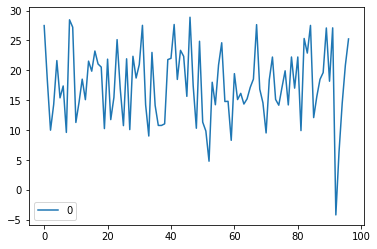

In [90]:
# Tesing the Model based on values from training X = Time , Y = Predicted temperature
testmodel = pd.DataFrame(model.predict(normed_test))
testmodel.plot()

In [91]:
# Predict what the TVOC will be after x amount of days
howmany = 90 # 10 days
answer = model.predict([normed_test[0:(howmany % len(normed_test))]])
print(f"The tvoc would be {answer.mean()} ppm after {howmany}")

The temperature would be 17.798154830932617 degrees after 90
